<a href="https://colab.research.google.com/github/davensethi/davensethi.github.io/blob/master/buildweek2(a).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving true_car_listings.csv to true_car_listings.csv


In [2]:
%%capture
import pandas as pd 
df = pd.read_csv('true_car_listings.csv')
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ridge_regression,Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [5]:
#from pylab import rcParams

#rcParams['figure.figsize'] = 10,5

#df['Price'].plot.bar(color='red')

In [6]:
df=df.drop(columns='Vin')

In [7]:
target ='Price'
X = df.drop(target, axis=1)
y= df[target]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

In [9]:
X_train.shape,X_test.shape, y_train.shape,y_test.shape

((681697, 6), (170425, 6), (681697,), (170425,))

In [10]:
print ('baseline mean',y_train.mean())
print('baseline mean absolute error',mean_absolute_error(y_train, [y_train.mean()]*len(y_train)))

baseline mean 21458.124809116074
baseline mean absolute error 9110.433211338232


In [11]:
model_F = make_pipeline(
    OrdinalEncoder(),
    RandomForestRegressor()
)

model_F.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['City', 'State', 'Make', 'Model'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'City',
                                          'data_type': dtype('O'),
                                          'mapping': Wichita            1
Columbia           2
Longmont           3
Jacksonville       4
Union City         5
                ... 
Holbrook        2550
Broken Bow      2551
Royston         2552
Armona          2553
NaN               -2
Length: 2554, dtype: int64},
                                         {...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                              

In [12]:
y_predict_F = model_F.predict(X_test)
print('mean absolute error', mean_absolute_error(y_test, y_predict_F))

mean absolute error 2284.0343050125625


In [13]:
r2_score(y_test,y_predict_F)

0.8962229582022362

In [14]:
model_regression = make_pipeline(
    OrdinalEncoder(),
    Ridge()
)

model_regression.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['City', 'State', 'Make', 'Model'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'City',
                                          'data_type': dtype('O'),
                                          'mapping': Wichita            1
Columbia           2
Longmont           3
Jacksonville       4
Union City         5
                ... 
Holbrook        2550
Broken Bow      2551
Royston         2552
Armona          2553
NaN               -2
Length: 2554, dtype: int64},
                                         {...
                                         {'col': 'Model',
                                          'data_type': dtype('O'),
                                          'mapping': TraverseAWD        1
Liberty4WD         2
Escape4WD          3
CamrySE     

In [15]:
y_predict_L = model_regression.predict(X_test)
print('mean absolute error', mean_absolute_error(y_test, y_predict_L))

mean absolute error 7921.223090160728


In [16]:

r2_score(y_test,y_predict_L)

0.21013363609852231

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:

# The ranges you want to test, as a dictionary
params = {'randomforestregressor__n_estimators': range(50, 201, 50), # 4 options
          'randomforestregressor__max_depth': range(5, 26, 10)} # 3 options

# Create your gridsearch
gs = GridSearchCV(model_F,
                  param_grid=params,
                  n_jobs=-1,
                  verbose=1,
                  cv=5
)    

In [19]:
#gs.fit(X_train,y_train)

In [20]:
classifier=model_F.named_steps['randomforestregressor']
feature_importance = classifier.feature_importances_
feature_imp_s= pd.Series(feature_importance, index=X_train.columns).sort_values(ascending=False)

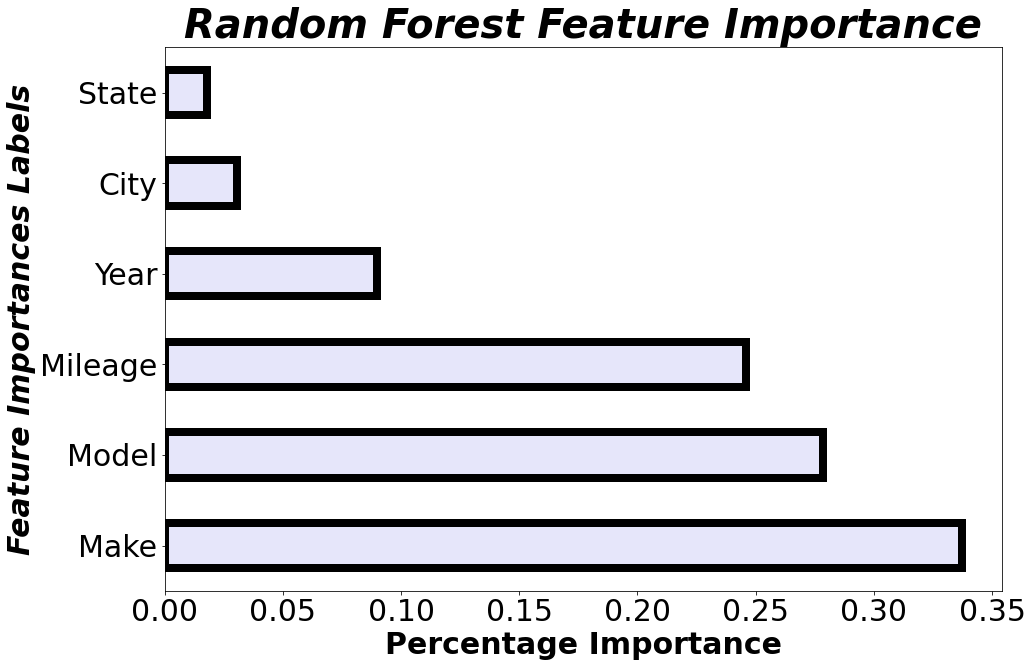

In [21]:
from pylab import rcParams

rcParams['figure.figsize'] = 15, 10
fig, ax = plt.subplots()
feature_imp_s.head(10).plot(kind='barh', color='lavender', edgecolor='black', linewidth = 8)
plt.xlabel("Percentage Importance",fontsize=30,fontweight='bold')
plt.ylabel("Feature Importances Labels",fontsize=30,fontweight='bold',style='italic',)
plt.title("Random Forest Feature Importance",fontsize=40,style='italic',fontweight='bold')
plt.xticks(fontsize= 30) 
plt.yticks(fontsize= 30) 
plt.show()

In [22]:
model_XGB = make_pipeline(
    OrdinalEncoder(),
    XGBRegressor()
)

model_XGB.fit(X_train,y_train)

[15:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['City', 'State', 'Make', 'Model'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'City',
                                          'data_type': dtype('O'),
                                          'mapping': Wichita            1
Columbia           2
Longmont           3
Jacksonville       4
Union City         5
                ... 
Holbrook        2550
Broken Bow      2551
Royston         2552
Armona          2553
NaN               -2
Length: 2554, dtype: int64},
                                         {...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, ma

In [23]:
y_predict_XGB = model_XGB.predict(X_test)
print('mean absolute error', mean_absolute_error(y_test, y_predict_XGB))


mean absolute error 5697.389518790909


In [24]:
print('XGB R2 score', r2_score(y_test,y_predict_XGB))

XGB R2 score 0.5752378254131401


In [25]:
model_Gradient = make_pipeline(
    OrdinalEncoder(),
    GradientBoostingRegressor()
)

model_Gradient.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['City', 'State', 'Make', 'Model'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'City',
                                          'data_type': dtype('O'),
                                          'mapping': Wichita            1
Columbia           2
Longmont           3
Jacksonville       4
Union City         5
                ... 
Holbrook        2550
Broken Bow      2551
Royston         2552
Armona          2553
NaN               -2
Length: 2554, dtype: int64},
                                         {...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                         

In [26]:
y_predict_gradient = model_Gradient.predict(X_test)
print('mean absolute error', mean_absolute_error(y_test, y_predict_gradient))


mean absolute error 5744.599973833333


In [27]:
print('XGradient R2 score', r2_score(y_test,y_predict_gradient))

XGradient R2 score 0.5745917861791042


In [28]:
from sklearn.inspection import permutation_importance

In [29]:
p_importance=permutation_importance(model_F, X_test, y_test)

In [30]:
p_importance.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [31]:
p_importance.importances

array([[0.4030151 , 0.40537934, 0.3939516 , 0.40442672, 0.39811618],
       [0.42552833, 0.4368455 , 0.40258923, 0.41958944, 0.42048601],
       [0.00539729, 0.0061999 , 0.00580588, 0.00589608, 0.00644088],
       [0.0048319 , 0.0054682 , 0.00532249, 0.00448072, 0.00463278],
       [1.23951138, 1.21674896, 1.22699073, 1.2161083 , 1.21701424],
       [0.64800704, 0.64315618, 0.6450285 , 0.654745  , 0.64555501]])

In [32]:
data = {'importances_mean' : p_importance['importances_mean'],
        'importances_std' : p_importance['importances_std'],
          }


df = pd.DataFrame(data, index=X_test.columns)
df.sort_values('importances_mean', ascending=False, inplace=True)


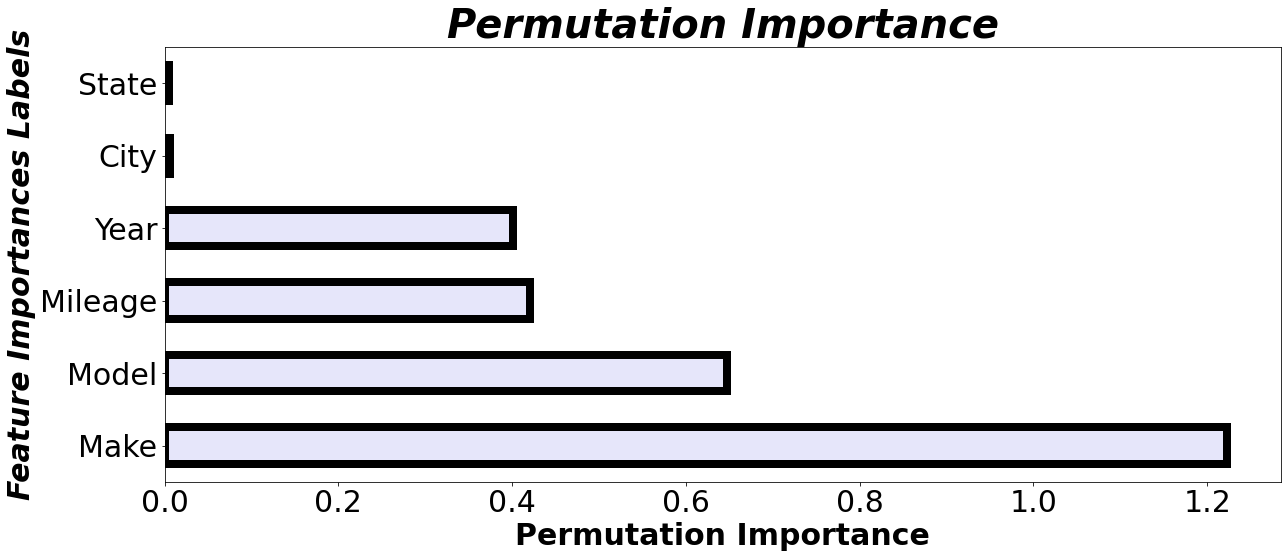

In [33]:
rcParams['figure.figsize'] = 20, 8
#fig, ax = plt.subplots()
df.importances_mean.plot(kind='barh', color='lavender', edgecolor='black', linewidth = 8)

plt.xlabel("Permutation Importance",fontsize=30,fontweight='bold')
plt.ylabel("Feature Importances Labels",fontsize=30,fontweight='bold',style='italic',)
plt.title("Permutation Importance",fontsize=40,style='italic',fontweight='bold')
plt.xticks(fontsize= 30) 
plt.yticks(fontsize= 30) 
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


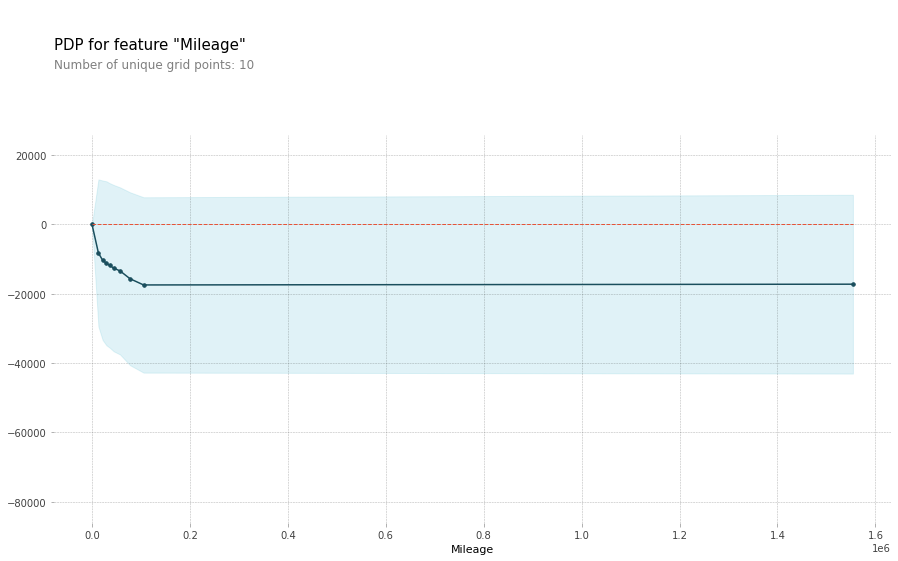

In [34]:
feature = 'Mileage'
isolated = pdp_isolate(
    model = model_F,
    dataset= X_test,
    model_features = X_test.columns,
    feature = feature
)
pdp_plot(isolated, feature_name=feature);

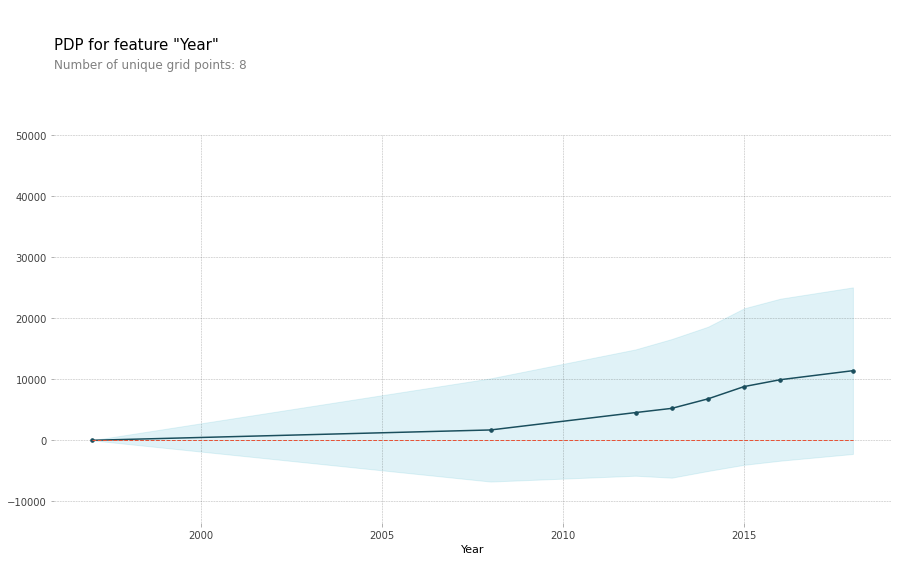

In [35]:
feature = 'Year'
isolated = pdp_isolate(
    model = model_F,
    dataset= X_test,
    model_features = X_test.columns,
    feature = feature
)
pdp_plot(isolated, feature_name=feature);